In [3]:
%pylab inline
import psycopg2
from pyiem.network import Table as NetworkTable
import pandas as pd
import datetime

#sts = datetime.datetime(2013,12,1)
#ets = datetime.datetime(2014,2,26,8)
#total = (ets - sts).days * 86400. + (ets - sts).seconds
total = (2015-1973)
ASOS = psycopg2.connect(database='asos', user='nobody',host='localhost', port=5555)
acursor = ASOS.cursor()

MESOSITE = psycopg2.connect(database='mesosite', user='nobody', host='localhost', port=5555)
mcursor = MESOSITE.cursor()

networks = ['AWOS',]
mcursor.execute("""SELECT distinct network from stations where country = 'US' and 
 network ~* 'ASOS'""")
for row in mcursor:
    networks.append( row[0] )

#nt = network.Table(('IA_ASOS','MO_ASOS','IL_ASOS', 'ND_ASOS', 'AWOS',
#          'WI_ASOS','MN_ASOS', 'SD_ASOS', 'NE_ASOS', 'KS_ASOS',
#          'IN_ASOS','KY_ASOS','OH_ASOS','MI_ASOS'))
nt = NetworkTable(networks)
rows = []
for sid in nt.sts.keys():
    if nt.sts[sid]['archive_begin'] is None or nt.sts[sid]['archive_begin'].year > 1973:
        continue
        
    # Figure out what our archive coverage is, 41 years would be perfect
    acursor.execute("""
    select yr from 
        (SELECT substring(d, 1, 4) as yr, count(*) from 
            (select distinct to_char(valid, 'YYYYmmddHH24') as d from alldata 
            where station = %s and valid > '1973-01-01' and valid < '2015-01-01') as foo 
        GROUP by yr) as foo2 
    WHERE count > (365. * 24 * .9)
    """, (sid,) )
    if acursor.rowcount < 37:
        print 'Skipping %s, due to only have %s/41 years of data' % (sid, acursor.rowcount)
        continue
        
    acursor.execute("""
  with delta as (select valid, tmpf - lag(tmpf) OVER (ORDER by valid ASC) as deleta 
  from alldata where station = %s and tmpf is not null and valid > '1973-01-01'), 
  
  cnts as (select date(valid at time zone %s)  as d, sum(case when deleta > 0 then 1 else 0 end), 
  count(*) from delta GROUP by d) 
  
  SELECT count(*) from cnts where count > 20 and sum = 0
""", (sid, nt.sts[sid]['tzname']))
    
    row = acursor.fetchone()
    rows.append(dict(sid=sid, lat=nt.sts[sid]['lat'], lon=nt.sts[sid]['lon'],
                      val=row[0], network=nt.sts[sid]['network']))
    print sid, row[0] / float(total) * 100., row[0]

df = pd.DataFrame(rows)

Populating the interactive namespace from numpy and matplotlib
AGC 90.4761904762 38
Skipping NYC, due to only have 15/41 years of data
AGS 28.5714285714 12
Skipping NYG, due to only have 26/41 years of data
Skipping PHMK, due to only have 24/41 years of data
PKB 76.1904761905 32
SPS 16.6666666667 7
SPI 73.8095238095 31
Skipping BWD, due to only have 12/41 years of data
BWG 42.8571428571 18
BWI 30.9523809524 13
Skipping PADK, due to only have 31/41 years of data
Skipping PADL, due to only have 29/41 years of data
Skipping IXD, due to only have 16/41 years of data
PADQ 78.5714285714 33
Skipping PADU, due to only have 21/41 years of data
Skipping BYH, due to only have 19/41 years of data
Skipping BYI, due to only have 33/41 years of data
Skipping JNW, due to only have 0/41 years of data
Skipping SNA, due to only have 15/41 years of data
Skipping PQI, due to only have 20/41 years of data
Skipping B23, due to only have 0/41 years of data
SNS 0.0 0
MAF 16.6666666667 7
Skipping MAI, due to on

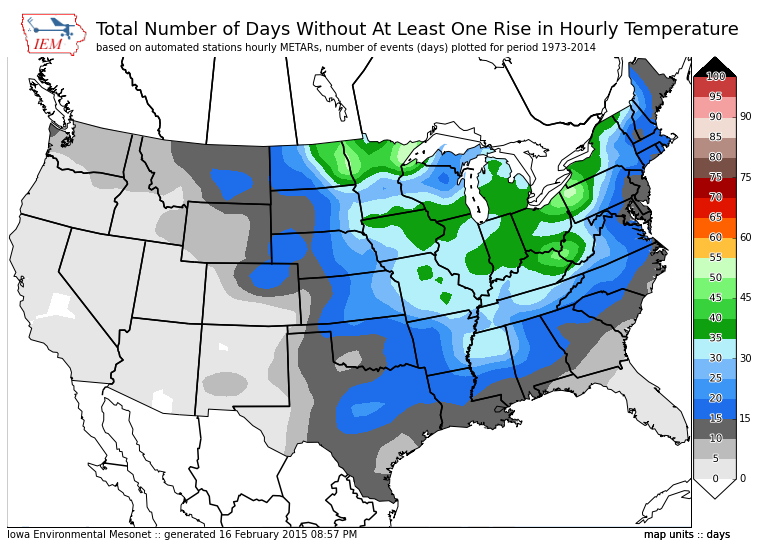

In [9]:
df = pd.DataFrame(rows)
from pyiem.plot import MapPlot
import numpy as np

df2 = df[df.sid != 'BNW']

m = MapPlot(sector='conus', title="Total Number of Days Without At Least One Rise in Hourly Temperature",
            subtitle="based on automated stations hourly METARs, number of events (days) plotted for period 1973-2014")
m.contourf(np.array(df2.lon), np.array(df2.lat), np.array(df2.val), np.arange(0,101,5), units='days')
#m.plot_values(df2.lon, df2.lat, df2.val, fmt='%.0f')
m.postprocess(filename='test.png')

